In [192]:
import os
from sam import chdir_to_repopath
chdir_to_repopath()
from sam.dose_reponse_fit import dose_response_fit, ModelPredictions, survival_to_stress, FitSettings, Transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sam.data_formats import read_data, load_files, load_datapoints
from sam.plotting import plot_fit_prediction
from sam.system_stress import pred_surv_without_hormesis
from sam.helpers import detect_hormesis_index, pad_c0, compute_lc_from_curve, weibull_2param, weibull_2param_inverse, compute_lc, ll5_inv
from sam.data_formats import ExperimentData
from scipy.optimize import brentq
import seaborn as sns
from sam.stress_addition_model import OLD_STANDARD, sam_prediction, get_sam_lcs, stress_to_survival, survival_to_stress
from tqdm import tqdm

In [55]:
ignore = [
    "huang_Flupyradifurone_2023",
    "imrana_copper_2024",
    "ayesha_chlorantran_2022_reference",
    "ayesha_chlorantran_2022_agriculture",
    "imrana_salt_2024",
    "naemm_Clothianidin_2024_reference",
    "imrana_2024_food",
]

ignore = [
    #     'bps_esf_food_2024.xlsx',
    #    'ayesha-cloth_Clothianidin_2024_agricultural.xlsx',
    #    'huang_imidachloprid_2023.xlsx',
    #    'ayesha-cloth_Clothianidin_2024_agricultural_pre-contamination.xlsx',
    #    'ayesha-cloth_Clothianidin_2024_reference_pre-contamination.xlsx',
    #    'naeem_Esfenvalerate_2019.xlsx',
]

ignore = [
    
    'imrana_salt_2024.xlsx',
       'ayesha_chlorantran_2022_agriculture.xlsx',
       'huang_Flupyradifurone_2023.xlsx',
       'ayesha_chlorantran_2022_reference.xlsx'
       'imrana_2024_food.xlsx',
       'imrana_copper_2024.xlsx'
       "ayesha_chlorantran_2022_reference.xlsx",
    
]

filter_func = lambda path: not any(i in path for i in ignore)

In [56]:
def predict_cleaned_curv(data : ExperimentData):
    
    
    
    concentration = pad_c0(data.main_series.concentration).copy()
    survival_tox_observerd = np.copy(data.main_series.survival_rate / data.meta.max_survival)
    
    if data.meta.hormesis_concentration is None:
    
        hormesis_index = detect_hormesis_index(survival_tox_observerd)
        
        if hormesis_index is None:
            hormesis_index = 1
    
    else:
        hormesis_index = np.argwhere(data.meta.hormesis_concentration == data.main_series.concentration)[0,0]
    
    func, _, popt = pred_surv_without_hormesis(concentration=concentration, surv_withhormesis=survival_tox_observerd, hormesis_index=hormesis_index)
    
    return func, hormesis_index, popt

In [57]:
def gen_func(stress, cleaned_func):
    
    def func(x, stress):
        
        y = cleaned_func(x)
        
        stress = survival_to_stress(y) + stress
        
        return stress_to_survival(stress)
        
    return np.vectorize(lambda x: func(x,  stress = stress))

def find_lc_brentq(func, lc, min_v = 1e-8, max_v = 100000):
    
    
    left_val = func(min_v)
    lc = (100 - lc) / 100 * left_val
    
    brent_func = lambda x : func(x) - lc
    
    return brentq(brent_func, min_v, max_v)

In [58]:
stresses = np.linspace(0, 0.6, 100)


def compute_lc_trajectory(path: str):

    data = read_data(path)

    cfg = FitSettings(
        survival_max=data.meta.max_survival,
        param_d_norm=True,
    )

    fit = dose_response_fit(data.main_series, cfg)
    cleaned_func, hormesis_index, popt = predict_cleaned_curv(data)

    x = fit.concentration_curve

    lcs = []

    for stress in stresses:

        func = gen_func(stress, cleaned_func=fit.model)

        lcs.append(
            (
                find_lc_brentq(func, 10, max_v=x.max()),
                find_lc_brentq(func, 50, max_v=x.max()),
            )
        )

    return np.array(lcs)

results = {}

for path, _ in tqdm(load_files(filter_func)):
    
    results[path] = compute_lc_trajectory(path)

100%|██████████| 15/15 [00:19<00:00,  1.27s/it]


In [59]:
lc10 = np.array([i[:,0] for i in results.values()])
lc50 = np.array([i[:,1] for i in results.values()])

/tmp/ipykernel_68537/2170627063.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {chemical: color for chemical, color in zip(set(chemicals), plt.cm.get_cmap('tab10').colors)}


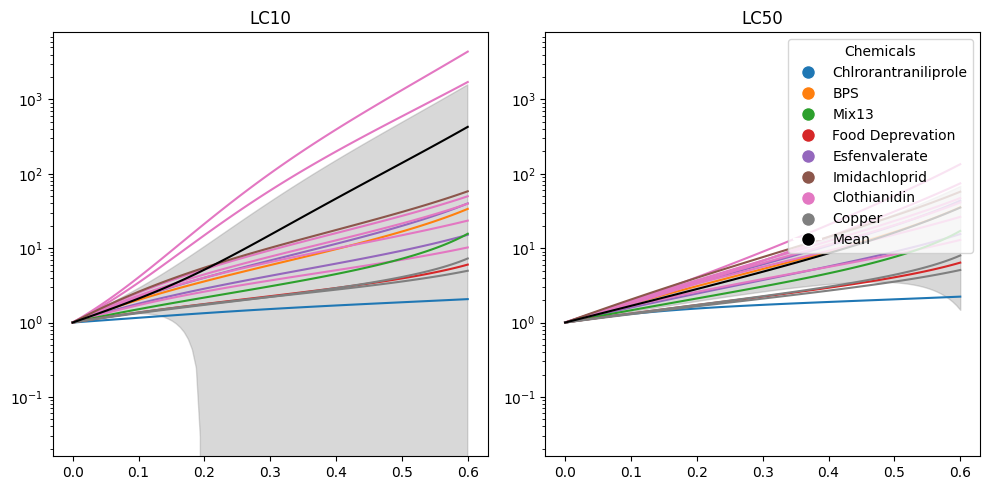

In [60]:
chemicals = [i.meta.chemical for _, i in load_files(filter_func)]
color_map = {chemical: color for chemical, color in zip(set(chemicals), plt.cm.get_cmap('tab10').colors)}
color_map["Mean"] = "black"

def plot_with_mean_std(ax, lc_data, chemicals, stresses, color_map, title):
    for ar, chem in zip(lc_data, chemicals):
        ax.plot(stresses, ar[0] / ar, color=color_map[chem])

    # Calculate mean and std
    mean_curve = np.mean([ar[0] / ar for ar in lc_data], axis=0)
    ax.plot(stresses, mean_curve, color='black', label='Mean')

    std_curve = np.std([ar[0] / ar for ar in lc_data], axis=0)

    ax.fill_between(stresses, mean_curve - std_curve, mean_curve + std_curve, color='gray', alpha=0.3, label='Std Dev')
    ax.set_yscale('log')
    ax.set_title(title)

# Create subplots
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
plot_with_mean_std(ax1, lc10, chemicals, stresses, color_map, "LC10")

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
plot_with_mean_std(ax2, lc50, chemicals, stresses, color_map, "LC50")

# Create legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=chemical)
                   for chemical, color in color_map.items()]
plt.legend(handles=legend_elements, title="Chemicals", loc='upper right')

# Show plot
plt.tight_layout()
plt.show()

In [62]:
paths =np.array([p for p,i in load_files(filter=filter_func)])

diff = lc10[:,0][:, None] / lc10

paths[np.argsort(diff.max(-1))[::-1]]

array(['/home/felix/Desktop/sam/data/naemm_Clothianidin_2024_agricultural.xlsx',
       '/home/felix/Desktop/sam/data/naemm_Clothianidin_2024_reference.xlsx',
       '/home/felix/Desktop/sam/data/huang_imidachloprid_2023.xlsx',
       '/home/felix/Desktop/sam/data/ayesha-cloth_Clothianidin_2024_agricultural_pre-contamination.xlsx',
       '/home/felix/Desktop/sam/data/naeem_Esfenvalerate_2019.xlsx',
       '/home/felix/Desktop/sam/data/ayesha-cloth_Clothianidin_2024_agricultural.xlsx',
       '/home/felix/Desktop/sam/data/bps_esf_food_2024.xlsx',
       '/home/felix/Desktop/sam/data/ayesha-cloth_Clothianidin_2024_reference_pre-contamination.xlsx',
       '/home/felix/Desktop/sam/data/naeem_Mix13_2024.xlsx',
       '/home/felix/Desktop/sam/data/naeem_Esfenvalerate_2024.xlsx',
       '/home/felix/Desktop/sam/data/ayesha-cloth_Clothianidin_2024_reference.xlsx',
       '/home/felix/Desktop/sam/data/liess_copper_2001.xlsx',
       '/home/felix/Desktop/sam/data/imrana_2024_food.xlsx',
      

In [51]:
dfs = []


for path, data, stress_name, stress_series in load_datapoints():
    meta = data.meta

    main_fit, stress_fit, sam_sur, sam_stress, additional_stress = sam_prediction(
        data.main_series,
        stress_series,
        data.meta,
        settings=OLD_STANDARD,
    )

    lcs = get_sam_lcs(stress_fit=stress_fit, sam_sur=sam_sur, meta=data.meta)
    
    main_lc10 = compute_lc(optim_param=main_fit.optim_param, lc=10)
    main_lc50 = compute_lc(optim_param=main_fit.optim_param, lc=50)

    dfs.append(
        {
            "title": path[:-4],
            "chemical": meta.chemical,
            "organism": meta.organism,
            "main_fit": main_fit,
            "stress_fit": stress_fit,
            "stress_name": stress_name,
            "main_lc10":main_lc10,
            "main_lc50":main_lc50,
            "stress_lc10" : lcs.stress_lc10,
            "stress_lc50" : lcs.stress_lc50,
            "sam_lc10" : lcs.sam_lc10,
            "sam_lc50" : lcs.sam_lc50,
        }
    )

df = pd.DataFrame(dfs)
df.head()

,title,chemical,organism,main_fit,stress_fit,stress_name,main_lc10,main_lc50,stress_lc10,stress_lc50,sam_lc10,sam_lc50
0,/home/felix/Desktop/sam/data/huang_Flupyradifu...,Flupyradifurone,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_15,12.103473,24.217719,2.769818,16.013050,4.998847,13.643113
1,/home/felix/Desktop/sam/data/naeem_Esfenvalera...,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Prochloraz_1,0.034669,0.435088,0.076167,0.550485,0.034712,0.435554
2,/home/felix/Desktop/sam/data/naeem_Esfenvalera...,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Prochloraz_32,0.034669,0.435088,0.024069,0.184989,0.000886,0.079306
3,/home/felix/Desktop/sam/data/naeem_Esfenvalera...,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Prochloraz_100,0.034669,0.435088,0.005427,0.151644,0.000886,0.079306
4,/home/felix/Desktop/sam/data/naeem_Esfenvalera...,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Food_1%,0.034669,0.435088,0.000186,0.037144,0.000291,0.046408


In [52]:
interest  = [
    ("liess_copper_2001", "Food_1% + UV"),
    ("naeem_Esfenvalerate_2019", "Food_1% + Prochloraz_100"),
    ("naeem_Esfenvalerate_2019", "Food_1% + Prochloraz_32"),
    ("naeem_Esfenvalerate_2024", "Food_1% + Temp_25"),
    ("naeem_Mix13_2024", "Temp_25 + Food_1%")
]

mask = df.apply(lambda x: any(path in x.title and stress in x.stress_name for path, stress in interest), axis = 1)

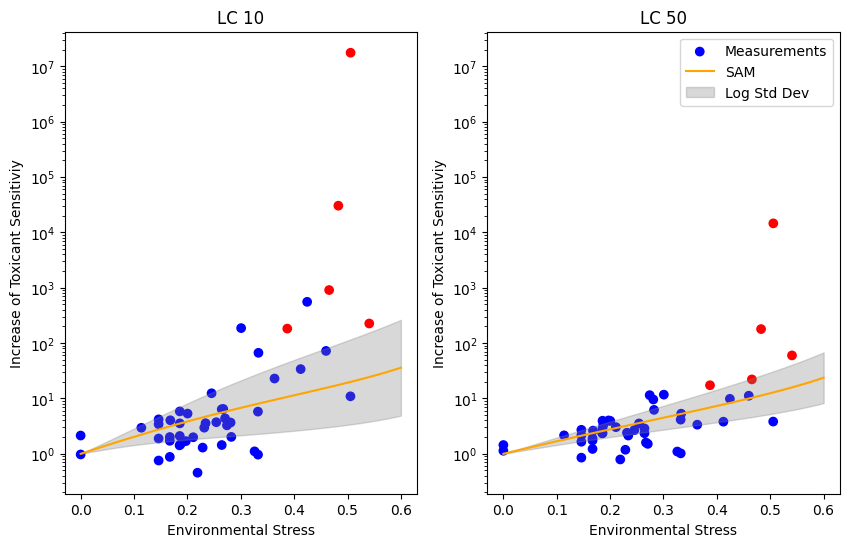

In [53]:
df["true_10_frac"] = df.main_lc10 / df.stress_lc10
df["true_50_frac"] = df.main_lc50 / df.stress_lc50


log_lc10 = [np.log(ar[0] / ar) for ar in lc10]
log_lc50 = [np.log(ar[0] / ar) for ar in lc50]

# Calculate the mean and std in the log-space
log_mean_curve_10 = np.mean(log_lc10, axis=0)
log_std_curve_10 = np.std(log_lc10, axis=0)

log_mean_curve_50 = np.mean(log_lc50, axis=0)
log_std_curve_50 = np.std(log_lc50, axis=0)

# Exponentiate back to the original scale
mean_curve_10 = np.exp(log_mean_curve_10)
upper_curve_10 = np.exp(log_mean_curve_10 + log_std_curve_10)
lower_curve_10 = np.exp(log_mean_curve_10 - log_std_curve_10)

mean_curve_50 = np.exp(log_mean_curve_50)
upper_curve_50 = np.exp(log_mean_curve_50 + log_std_curve_50)
lower_curve_50 = np.exp(log_mean_curve_50 - log_std_curve_50)



df["stress_level"] = df.stress_fit.apply(lambda x: survival_to_stress(x.optim_param["d"]))


y_name = "Increase of Toxicant Sensitiviy"
x_name = "Environmental Stress"

plt.figure(figsize=(10,6))
ax1 = plt.subplot(1,2,1)
plt.title("LC 10")

color = ["blue" if not i else "red" for i in mask]

plt.scatter(df.stress_level, df["true_10_frac"], label = "Measurements", color = color)


ax1.plot(stresses, mean_curve_10, color='orange', label='SAM')
ax1.fill_between(stresses, lower_curve_10, upper_curve_10, color='gray', alpha=0.3, label='Log Std Dev')


plt.yscale("log")
plt.xlabel(x_name)
plt.ylabel(y_name)

plt.subplot(1,2,2, sharey = ax1)
plt.title("LC 50")

plt.scatter(df.stress_level, df["true_50_frac"], label = "Measurements", color = color)

plt.plot(stresses, mean_curve_50, color='orange', label='SAM')
plt.fill_between(stresses, lower_curve_50, upper_curve_50, color='gray', alpha=0.3, label='Log Std Dev')

plt.yscale("log")
plt.xlabel(x_name)
plt.ylabel(y_name)

plt.legend()
plt.show()